# Training a parametrized quantum circuit

* Create a circuin, use one from qiskit library

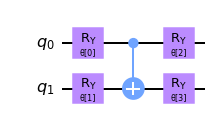

In [1]:
from qiskit.circuit.library import RealAmplitudes

# use the parametrized circuit Real amplitudes from qiskit library
ansatz = RealAmplitudes(num_qubits = 2, reps = 1, entanglement = 'linear').decompose()

ansatz.draw()

* Create the hamiltonian that will be applied to the system

In [2]:
# after that we need to define a Hamiltonian, we will use H = ZxZ
from qiskit.opflow import Z, I

# define the hamiltonian of the system 
hamiltonian = Z ^ Z

* Get the expectation value after acting the operator in the quantum state

In [3]:
# we need to compute the expectation value of the quantum state
from qiskit.opflow import StateFn, PauliExpectation

# create expectation value by applying the hamiltonian operator
expectation = StateFn(hamiltonian, is_measurement = True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

* Function to simulate the measurement of the expectation value

In [4]:
# next we simulate the measurement of the expectation value
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots = 8192, seed_simulator = 2717, seed_transpiler = 2718)

sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params = value_dict).eval()
    return np.real(result)

* Get finite difference gradients

$$\nabla{f(\theta)} = \frac{1}{2 \epsilon}(f(\theta + \epsilon) - f(\theta - \epsilon))$$

In [5]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

In [6]:
eps = 0.2

e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = evaluate_expectation(plus) - evaluate_expectation(minus) / (2 * eps)

print(finite_difference)

-0.5527343749999998


In [7]:
# we can use qiskit's Gradient class for gradianet descent method
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic = False, epsilon = eps)
grad = shifter.convert(expectation, params = ansatz.parameters[index])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


-0.06835937499999989

* Analytic gradients - parameter shift

In [8]:
# using the gradient class, parameter shift is the default rule
shifter = Gradient() 

# calculate the gradient
grad = shifter.convert(expectation, params = ansatz.parameters[index])

# normally should be pretty close to finite difference calculation
sampler.convert(grad, value_dict).eval().real

-0.08911132812499994

* Optimizing the expectation value

In [9]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

print(initial_point)

[0.43253681 0.09507794 0.42805949 0.34210341]


* Function to evaluate the gradient

In [10]:
grad = Gradient().convert(expectation)

grad_in_pauli = PauliExpectation().convert(grad)

sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x) :
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(grad_in_pauli, value_dict).eval()

    return np.real(result)

* Create class with the gradient descent routine

In [11]:
# include GradientDescent class
from qiskit.algorithms.optimizers import GradientDescent

# keep track of the loss during iteration
loss = []

def callback(nfecs, x, fx, stepsize) :
    loss.append(fx)

gd = GradientDescent(maxiter = 300, learning_rate = 0.01, callback = callback)

* Gradient descent optimization

In [12]:
# optimise the gradient
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size, evaluate_expectation, gradient_function = evaluate_gradient, initial_point = initial_point)

* Plot optimization results

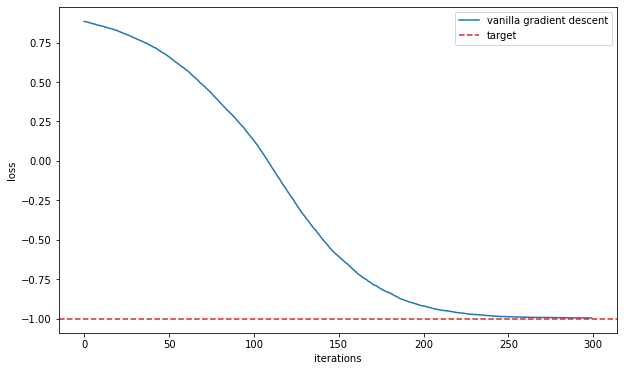

In [13]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10, 6))
plt.plot(loss, label = 'vanilla gradient descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();